# PyTorch 线性模型实践

有一组对未知温度单位到摄氏温度的映射数据，但当中存在一些噪声数据，需要排除这些噪声数据，并预测出近似的刻度值

In [1]:
import torch
t_c = [0.5, 14.0, 15.0, 28.0, 11.0, 8.0, 3.0, -4.0, 6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c)
t_u = torch.tensor(t_u)

在这里， `t_c` 值是以摄氏度为单位的温度，而 `t_u` 值是未知的单位。可以预期的是两组数据中的噪声来自设备本身和近似的刻度值。

## 模型准备

### 可视化数据

In [2]:
! pip install matplotlib

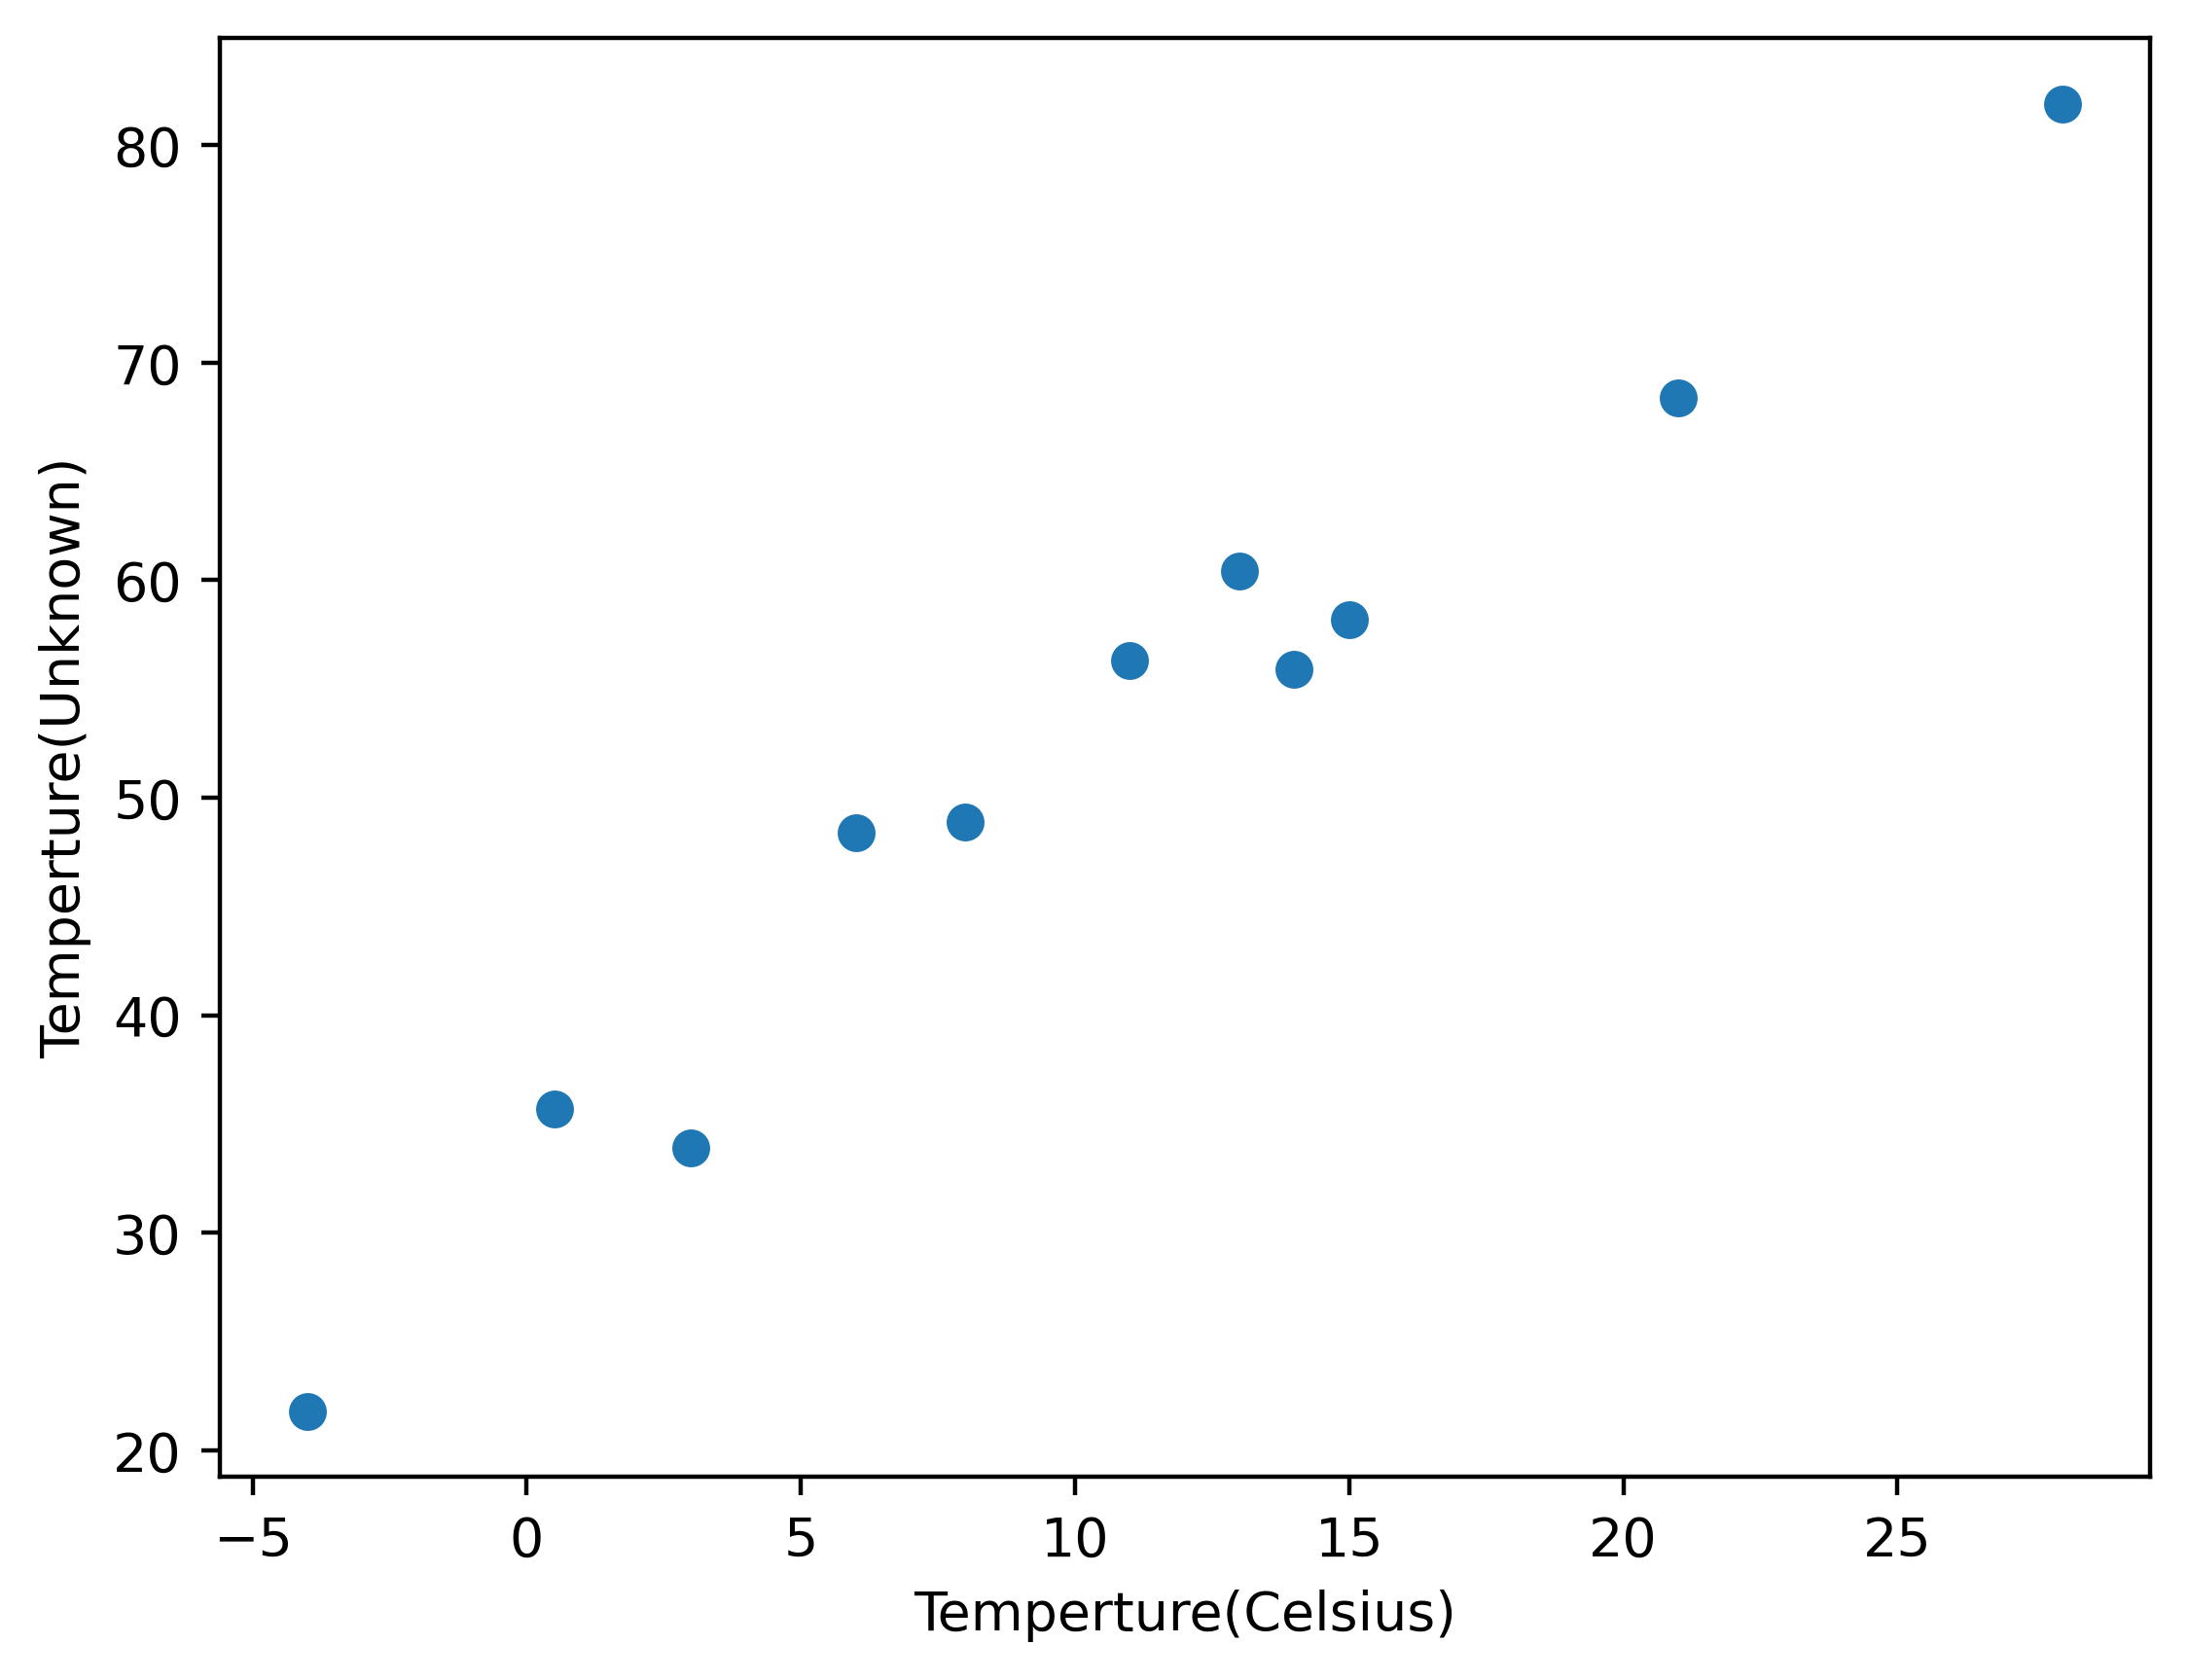

In [3]:
from matplotlib import pyplot as plt
plt.figure(dpi=400)
plt.xlabel("Temperture(Celsius)")
plt.ylabel("Temperture(Unknown)")
plt.plot(t_c.numpy(), t_u.numpy(), 'o')

从可视化数据出的图像可以看出数据整体是有规律的，但是存在噪声。

### 选择模型

在缺乏进一步了解的情况下，按照之前的可视化数据结果可以推测两个数据集是线性相关的————也就是说，将 `t_u` 乘一个因子，再加上一个长度就可以得到摄氏温度（忽略一定的误差）。

`t_c = w * t_u + b`

在上面的线性模型中，分别将权重和偏置名为 `w` 和 `b` ，现在就需要基于现有的数据来评估模型中的 `w` 和 `b` 参数。

目前我们有一个带有一些未知参数的模型，我们需要估计这些参数，使预测值和测量值之间的误差尽可能的小。预测值和测量值之间的误差也需要精确的定义，这种函数一般都被称为**损失函数**，如果误差很大，则说明损失函数的值大了。理想情况下应尽可能使损失函数的值交小，这样预测值和测量值二者可以完美匹配。因此，我们的优化过程应该是以找到 `w` 和 `b` 为目标，使损失函数的值处于最小值。

## 损失函数

**损失函数**（或代价函数）是一个计算单个数值的函数，学习过程将试图使其值最小化。损失的计算通常涉及一些*训练样本的期望输出*与*输入这些样本时模型实际产生的输出*之间的差值。在我们的这个个例子中，它将是模型输出的预测温度 `t_p` 与实际测量值之间的差值，即 `t_p-t_c`。

### 选取合适的损失函数

我们需要确保损失函数在 `t_p` 大于或小于真正的 `t_c` 时损失都为正，因为我们的目标时让 `t_p` 匹配 `t_c` (`t_p` 和 `t_c` 的差值尽可能的小)。目前有两个最直接的选择： `|t_p - t_c|` 和 `(t_p - t_c)^2` 。这两个损失函数在零点处都有一个明显的最小值，并且随着预测值在两个方向上远离真实值而单调递增。另外绝对值在收敛的地方存在一个不明确的导数，虽然这并不是什么大问题，但目前还是选在第二个平方差作为损失函数。另外，平方差比绝对差对错误结果的惩罚更大，通常有更多轻微错误的结果比有少量严重错误的结果更好。

接下来先定义模型函数：

In [4]:
def model(t_u, w, b):
    return w * t_u + b

我们期望 `t_u` 、 `w` 和 `b` 分别作为输入张量、权重参数和偏置参数。在我们的模型中，参数是 `PyTorch` 标量（也称为 0 维张量），通过乘积运算和广播生成返回的张量。接下来就要确定损失函数了：

In [5]:
def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c) ** 2
    return squared_diffs.mean()

在这个损失函数中，先构建了一个差分张量，然后对其值进行平方处理，最后通过对得到的张量中的所有元素求一次平均值得到一个标量损失函数，即均方损失函数。

我们现在可以初始化参数，调用模型：

In [6]:
w = torch.ones(())
b = torch.zeros(())

t_p = model(t_u, w, b)
t_p

tensor([35.7000, 55.9000, 58.2000, 81.9000, 56.3000, 48.9000, 33.9000, 21.8000,
        48.4000, 60.4000, 68.4000])

检查损失的值

In [7]:
loss = loss_fn(t_p, t_c)
loss

tensor(1763.8848)

## 梯度下降

### 更新步骤

梯度下降的基本思想是计算各参数的损失变化率，并在减小损失变化率的方向上修改各参数。我们可以通过在 `w` 和 `b` 上加一个小数字来估计变化率，然后看看损失在这附近的变化有多大。

In [8]:
delta = 0.1
loss_rate_of_change_w = (loss_fn(model(t_u, w + delta, b), t_c) - loss_fn(model(t_u, w - delta, b), t_c)) / (2.0 * delta)

上面代码的含义是：在当前的 `w` 和 `b` 的值附近， `w` 的变化会导致损失的一些变化。如果变化是负的，那么就需要增加 `w` 的值，如果变化是正的，那么就需要减小 `w` 的值。那么值具体增加或减少多少呢？对 `w` 运用一个与损失成比例的变化是一个很好的主意。一般来说，缓慢的改变参数也是明智的，因为在距离当前 `w` 值邻域很远的地方，损失变化的速率可能显著不同，因此，我们通常用一个很小的比例因子来衡量变化率，这个因子有很多名称，在机器学习中被称为学习率：

In [9]:
learning_rate = 1e-2
w = w - learning_rate * loss_rate_of_change_w

我们可以对 `b` 采用与 `w` 相同的处理方式

In [10]:
loss_rate_of_change_b = (loss_fn(model(t_u, w, b + delta), t_c) - loss_fn(model(t_u, w, b - delta), t_c)) / (2.0 * delta)
b = b - learning_rate * loss_rate_of_change_b

以上操作表示梯度下降基本参数的更新步骤。重复上面的步骤，我们将收敛到给定数据上使损失最小的参数的最优值。但这个方法相当粗糙，接下来看看更好的方式。

### 更好的梯度下降

通过对模型和损失的重复评估来探测损失函数在 `w` 和 `b` 邻域的行为，计算变化率，这在参数较多的模型中不太合适。此外，我们也不总是清楚邻域又多大，在这个例子中，我们选择了 `delta = 0.1` ，但这完全取决于由 `w` 和 `b` 构成的损失函数的形状。如果与 `delta` 相比，损失太快，那么就无法很好的知道损失在哪个方向上减小的最快。

如果我们能使邻域无限小，那就是最好的情况，这也正是分析所得到的损失对参数的导数时所发生的。在有 2 个或 2 个以上参数的模型中，我们计算每个参数的损失函数，并将它们放到一个导数向量中，即梯度。

为了计算损失对一个参数的导数，我们可以使用链式法则，先计算损失对其输入（模型输出）的导数，再乘模型对参数的导数导数。例：

`d(loss_fn) / d(w) = (d(loss_fn) / d(t_p)) * (d(t_p) / d(w))`

由于我们的这个模型使用的是线性函数，损失为平方差，据此算出导数为：

In [11]:
def dloss_fn(t_p, t_c):
    dsq_diffs = 2 * (t_p - t_c) / t_p.size(0)
    return dsq_diffs

由模型可以得到以下导数

In [12]:
# 模型对参数 w 的导数
def dmodel_dw(t_u, w, b):
    return t_u

In [13]:
# 模型对参数 b 的导数
def dmodel_db(t_u, w, b):
    return 1.0

把这些所有都放一起，返回关于 `w` 和 `b` 的损失梯度的函数：

In [14]:
def grad_fn(t_u, t_c, t_p, w, b):
    dloss_dtp = dloss_fn(t_p, t_c)
    dloss_dw = dloss_dtp * dmodel_dw(t_u, w, b)
    dloss_db = dloss_dtp * dmodel_db(t_u, w, b)
    return torch.stack([dloss_dw.sum(), dloss_db.sum()])

### 训练

现在我们已经做好了优化参数的准备。从某参数的假定值开始，我们可以对它应用更新，进行固定次数的迭代，也可以直到 `w` 和 `b` 停止变化为止。

我们一般把训练迭代称为迭代周期，在这个迭代周期，我们更新所有训练样本的参数。完整的训练循环如下：

In [15]:
def training_loop(n_epochs, learning_rate, params, t_u, t_c):
    for epoch in range(1, n_epochs + 1):
        w, b = params
        t_p = model(t_u, w, b)
        loss = loss_fn(t_p, t_c)
        grad = grad_fn(t_u, t_c, t_p, w, b)
        
        params = params - learning_rate * grad
        
        print('Epoch %d,Loss %f'%(epoch,float(loss)))
        print('\tParams: %s'%params)
        print('\tGrad:%s'%grad)
    return params

接下来调用训练循环：

In [16]:
training_loop(n_epochs = 100, learning_rate = 1e-2, params = torch.tensor([1.0, 0]), t_u = t_u, t_c = t_c)

Epoch 1,Loss 1763.884766
	Params: tensor([-44.1730,  -0.8260])
	Grad:tensor([4517.2964,   82.6000])
Epoch 2,Loss 5802484.500000
	Params: tensor([2568.4011,   45.1637])
	Grad:tensor([-261257.4062,   -4598.9702])
Epoch 3,Loss 19408029696.000000
	Params: tensor([-148527.7344,   -2616.3931])
	Grad:tensor([15109614.0000,   266155.6875])
Epoch 4,Loss 64915905708032.000000
	Params: tensor([8589999.0000,  151310.8906])
	Grad:tensor([-8.7385e+08, -1.5393e+07])
Epoch 5,Loss 217130525461053440.000000
	Params: tensor([-4.9680e+08, -8.7510e+06])
	Grad:tensor([5.0539e+10, 8.9023e+08])
Epoch 6,Loss 726257583152928129024.000000
	Params: tensor([2.8732e+10, 5.0610e+08])
	Grad:tensor([-2.9229e+12, -5.1486e+10])
Epoch 7,Loss 2429183416467662896627712.000000
	Params: tensor([-1.6617e+12, -2.9270e+10])
	Grad:tensor([1.6904e+14, 2.9776e+12])
Epoch 8,Loss 8125122549611731432050262016.000000
	Params: tensor([9.6102e+13, 1.6928e+12])
	Grad:tensor([-9.7764e+15, -1.7221e+14])
Epoch 9,Loss 27176882120842590626938

tensor([nan, nan])

由上面的结果可以看出训练过程奔溃了，导致损失变成了无穷。导致奔溃的原因是参数接收到的更新太大了，他们的值开始来回波动，因为每次更新过度修正，就会导致下一次更新更加过度。这个过程是发散的而不是收敛的，而我们希望的是一个收敛的优化。解决的方法也很简单，选择一个更小的学习率即可。事实上当训练进行得不像我们希望的那样好时，我们通常会改变学习率，所以可以尝试使用 1e-3 或 1e-4 ，现在试试 1e-4

In [17]:
training_loop(n_epochs = 100, learning_rate = 1e-4, params = torch.tensor([1.0, 0]), t_u = t_u, t_c = t_c)

Epoch 1,Loss 1763.884766
	Params: tensor([ 0.5483, -0.0083])
	Grad:tensor([4517.2964,   82.6000])
Epoch 2,Loss 323.090515
	Params: tensor([ 0.3623, -0.0118])
	Grad:tensor([1859.5493,   35.7843])
Epoch 3,Loss 78.929634
	Params: tensor([ 0.2858, -0.0135])
	Grad:tensor([765.4666,  16.5122])
Epoch 4,Loss 37.552845
	Params: tensor([ 0.2543, -0.0143])
	Grad:tensor([315.0790,   8.5787])
Epoch 5,Loss 30.540283
	Params: tensor([ 0.2413, -0.0149])
	Grad:tensor([129.6733,   5.3127])
Epoch 6,Loss 29.351154
	Params: tensor([ 0.2360, -0.0153])
	Grad:tensor([53.3495,  3.9682])
Epoch 7,Loss 29.148884
	Params: tensor([ 0.2338, -0.0156])
	Grad:tensor([21.9304,  3.4148])
Epoch 8,Loss 29.113848
	Params: tensor([ 0.2329, -0.0159])
	Grad:tensor([8.9964, 3.1869])
Epoch 9,Loss 29.107145
	Params: tensor([ 0.2325, -0.0162])
	Grad:tensor([3.6721, 3.0930])
Epoch 10,Loss 29.105247
	Params: tensor([ 0.2324, -0.0166])
	Grad:tensor([1.4803, 3.0544])
Epoch 11,Loss 29.104168
	Params: tensor([ 0.2323, -0.0169])
	Grad:te

tensor([ 0.2327, -0.0438])

现在优化过程已经稳定了，但还是有一个问题：参数接收到的更新非常小，所以损失下降的非常慢，最终停滞不前。我们可以通过学习率自适应来解决这个问题，但我们先处理另一个潜在的问题

### 归一化输入

从之前的输出可以看到，在第一个迭代周期，权重的梯度大约是偏置梯度的 50 倍。这意味着权重和偏置存在于不同的比例空间中，在这种情况下，如果学习率足够大，能够有效更新其中一个参数，那么对另一个参数来说，学习率就会变得不稳定，而一个只适合于另一个参数的学习率也不足以有意义地改变前者。这意味着我们无法有效的更新参数，除非我们改变模型公式，对每个参数都有一个学习率，但是这样模型又太麻烦了。

可以使用一中更简单的方法控制一切：改变输入，这样梯度就不会太大的不同。粗略地说，我们可以确保输入的范围不会偏离 -1.0～1.0太远。

In [18]:
t_nu = 0.1 * t_u

现在我们可以使用归一化后的输入运行循环训练了：

In [19]:
training_loop(n_epochs = 100, learning_rate = 1e-2, params = torch.tensor([1.0, 0]), t_u = t_nu, t_c = t_c)

Epoch 1,Loss 80.364342
	Params: tensor([1.7761, 0.1064])
	Grad:tensor([-77.6140, -10.6400])
Epoch 2,Loss 37.574913
	Params: tensor([2.0848, 0.1303])
	Grad:tensor([-30.8623,  -2.3864])
Epoch 3,Loss 30.871077
	Params: tensor([2.2094, 0.1217])
	Grad:tensor([-12.4631,   0.8587])
Epoch 4,Loss 29.756193
	Params: tensor([2.2616, 0.1004])
	Grad:tensor([-5.2218,  2.1327])
Epoch 5,Loss 29.507153
	Params: tensor([2.2853, 0.0740])
	Grad:tensor([-2.3715,  2.6310])
Epoch 6,Loss 29.392456
	Params: tensor([2.2978, 0.0458])
	Grad:tensor([-1.2492,  2.8241])
Epoch 7,Loss 29.298828
	Params: tensor([2.3059, 0.0168])
	Grad:tensor([-0.8071,  2.8970])
Epoch 8,Loss 29.208717
	Params: tensor([ 2.3122, -0.0124])
	Grad:tensor([-0.6325,  2.9227])
Epoch 9,Loss 29.119415
	Params: tensor([ 2.3178, -0.0417])
	Grad:tensor([-0.5633,  2.9298])
Epoch 10,Loss 29.030489
	Params: tensor([ 2.3232, -0.0710])
	Grad:tensor([-0.5355,  2.9295])
Epoch 11,Loss 28.941877
	Params: tensor([ 2.3284, -0.1003])
	Grad:tensor([-0.5240,  2.9

tensor([ 2.7553, -2.5162])

可以看到即使我们将学习率调回到 `1e-2` ，参数也不会在迭代更新中爆炸。然后再看看梯度：他们大小相似，所以对 2 个参数使用一个学习率就可以了。当然我们可以选择更好的方式来进行归一化操作，但目前为止已经足够满足要求了，所以就继续使用它。

在执行一次 5000 次的迭代循环：

In [20]:
params = training_loop(n_epochs = 5000, learning_rate = 1e-2, params = torch.tensor([1.0, 0]), t_u = t_nu, t_c = t_c)
params

Epoch 1,Loss 80.364342
	Params: tensor([1.7761, 0.1064])
	Grad:tensor([-77.6140, -10.6400])
Epoch 2,Loss 37.574913
	Params: tensor([2.0848, 0.1303])
	Grad:tensor([-30.8623,  -2.3864])
Epoch 3,Loss 30.871077
	Params: tensor([2.2094, 0.1217])
	Grad:tensor([-12.4631,   0.8587])
Epoch 4,Loss 29.756193
	Params: tensor([2.2616, 0.1004])
	Grad:tensor([-5.2218,  2.1327])
Epoch 5,Loss 29.507153
	Params: tensor([2.2853, 0.0740])
	Grad:tensor([-2.3715,  2.6310])
Epoch 6,Loss 29.392456
	Params: tensor([2.2978, 0.0458])
	Grad:tensor([-1.2492,  2.8241])
Epoch 7,Loss 29.298828
	Params: tensor([2.3059, 0.0168])
	Grad:tensor([-0.8071,  2.8970])
Epoch 8,Loss 29.208717
	Params: tensor([ 2.3122, -0.0124])
	Grad:tensor([-0.6325,  2.9227])
Epoch 9,Loss 29.119415
	Params: tensor([ 2.3178, -0.0417])
	Grad:tensor([-0.5633,  2.9298])
Epoch 10,Loss 29.030489
	Params: tensor([ 2.3232, -0.0710])
	Grad:tensor([-0.5355,  2.9295])
Epoch 11,Loss 28.941877
	Params: tensor([ 2.3284, -0.1003])
	Grad:tensor([-0.5240,  2.9

Epoch 1431,Loss 3.135702
	Params: tensor([  5.0959, -15.7662])
	Grad:tensor([-0.0462,  0.2618])
Epoch 1432,Loss 3.134994
	Params: tensor([  5.0964, -15.7688])
	Grad:tensor([-0.0461,  0.2614])
Epoch 1433,Loss 3.134292
	Params: tensor([  5.0968, -15.7714])
	Grad:tensor([-0.0461,  0.2609])
Epoch 1434,Loss 3.133590
	Params: tensor([  5.0973, -15.7740])
	Grad:tensor([-0.0460,  0.2605])
Epoch 1435,Loss 3.132889
	Params: tensor([  5.0978, -15.7766])
	Grad:tensor([-0.0459,  0.2600])
Epoch 1436,Loss 3.132194
	Params: tensor([  5.0982, -15.7792])
	Grad:tensor([-0.0459,  0.2596])
Epoch 1437,Loss 3.131500
	Params: tensor([  5.0987, -15.7818])
	Grad:tensor([-0.0458,  0.2592])
Epoch 1438,Loss 3.130810
	Params: tensor([  5.0991, -15.7844])
	Grad:tensor([-0.0457,  0.2587])
Epoch 1439,Loss 3.130119
	Params: tensor([  5.0996, -15.7870])
	Grad:tensor([-0.0456,  0.2583])
Epoch 1440,Loss 3.129432
	Params: tensor([  5.1000, -15.7895])
	Grad:tensor([-0.0455,  0.2578])
Epoch 1441,Loss 3.128746
	Params: tensor

Epoch 3086,Loss 2.928395
	Params: tensor([  5.3514, -17.2125])
	Grad:tensor([-0.0028,  0.0157])
Epoch 3087,Loss 2.928392
	Params: tensor([  5.3514, -17.2127])
	Grad:tensor([-0.0027,  0.0157])
Epoch 3088,Loss 2.928389
	Params: tensor([  5.3515, -17.2128])
	Grad:tensor([-0.0027,  0.0157])
Epoch 3089,Loss 2.928386
	Params: tensor([  5.3515, -17.2130])
	Grad:tensor([-0.0027,  0.0156])
Epoch 3090,Loss 2.928383
	Params: tensor([  5.3515, -17.2131])
	Grad:tensor([-0.0028,  0.0156])
Epoch 3091,Loss 2.928382
	Params: tensor([  5.3516, -17.2133])
	Grad:tensor([-0.0028,  0.0156])
Epoch 3092,Loss 2.928379
	Params: tensor([  5.3516, -17.2134])
	Grad:tensor([-0.0027,  0.0155])
Epoch 3093,Loss 2.928378
	Params: tensor([  5.3516, -17.2136])
	Grad:tensor([-0.0027,  0.0155])
Epoch 3094,Loss 2.928375
	Params: tensor([  5.3516, -17.2137])
	Grad:tensor([-0.0027,  0.0155])
Epoch 3095,Loss 2.928372
	Params: tensor([  5.3517, -17.2139])
	Grad:tensor([-0.0027,  0.0155])
Epoch 3096,Loss 2.928370
	Params: tensor

	Params: tensor([  5.3668, -17.2995])
	Grad:tensor([-0.0002,  0.0009])
Epoch 4773,Loss 2.927650
	Params: tensor([  5.3668, -17.2995])
	Grad:tensor([-0.0002,  0.0009])
Epoch 4774,Loss 2.927649
	Params: tensor([  5.3668, -17.2995])
	Grad:tensor([-0.0002,  0.0009])
Epoch 4775,Loss 2.927650
	Params: tensor([  5.3668, -17.2995])
	Grad:tensor([-0.0002,  0.0009])
Epoch 4776,Loss 2.927647
	Params: tensor([  5.3668, -17.2996])
	Grad:tensor([-0.0002,  0.0009])
Epoch 4777,Loss 2.927648
	Params: tensor([  5.3668, -17.2996])
	Grad:tensor([-0.0002,  0.0009])
Epoch 4778,Loss 2.927647
	Params: tensor([  5.3668, -17.2996])
	Grad:tensor([-0.0002,  0.0009])
Epoch 4779,Loss 2.927650
	Params: tensor([  5.3668, -17.2996])
	Grad:tensor([-0.0002,  0.0009])
Epoch 4780,Loss 2.927649
	Params: tensor([  5.3668, -17.2996])
	Grad:tensor([-0.0002,  0.0009])
Epoch 4781,Loss 2.927648
	Params: tensor([  5.3668, -17.2996])
	Grad:tensor([-0.0002,  0.0009])
Epoch 4782,Loss 2.927648
	Params: tensor([  5.3668, -17.2996])
	G

tensor([  5.3671, -17.3012])

当我们沿着梯度下降的方向改变参数时，我们的损失减小了，但它不会完全的趋近于零，这意味着迭代次数不足以使其收敛到零，或者数据点完全不在同一条线上。正如我们所预期的，开始的数据不是完全准确的，或者读数中有噪音。

接下来绘制数据

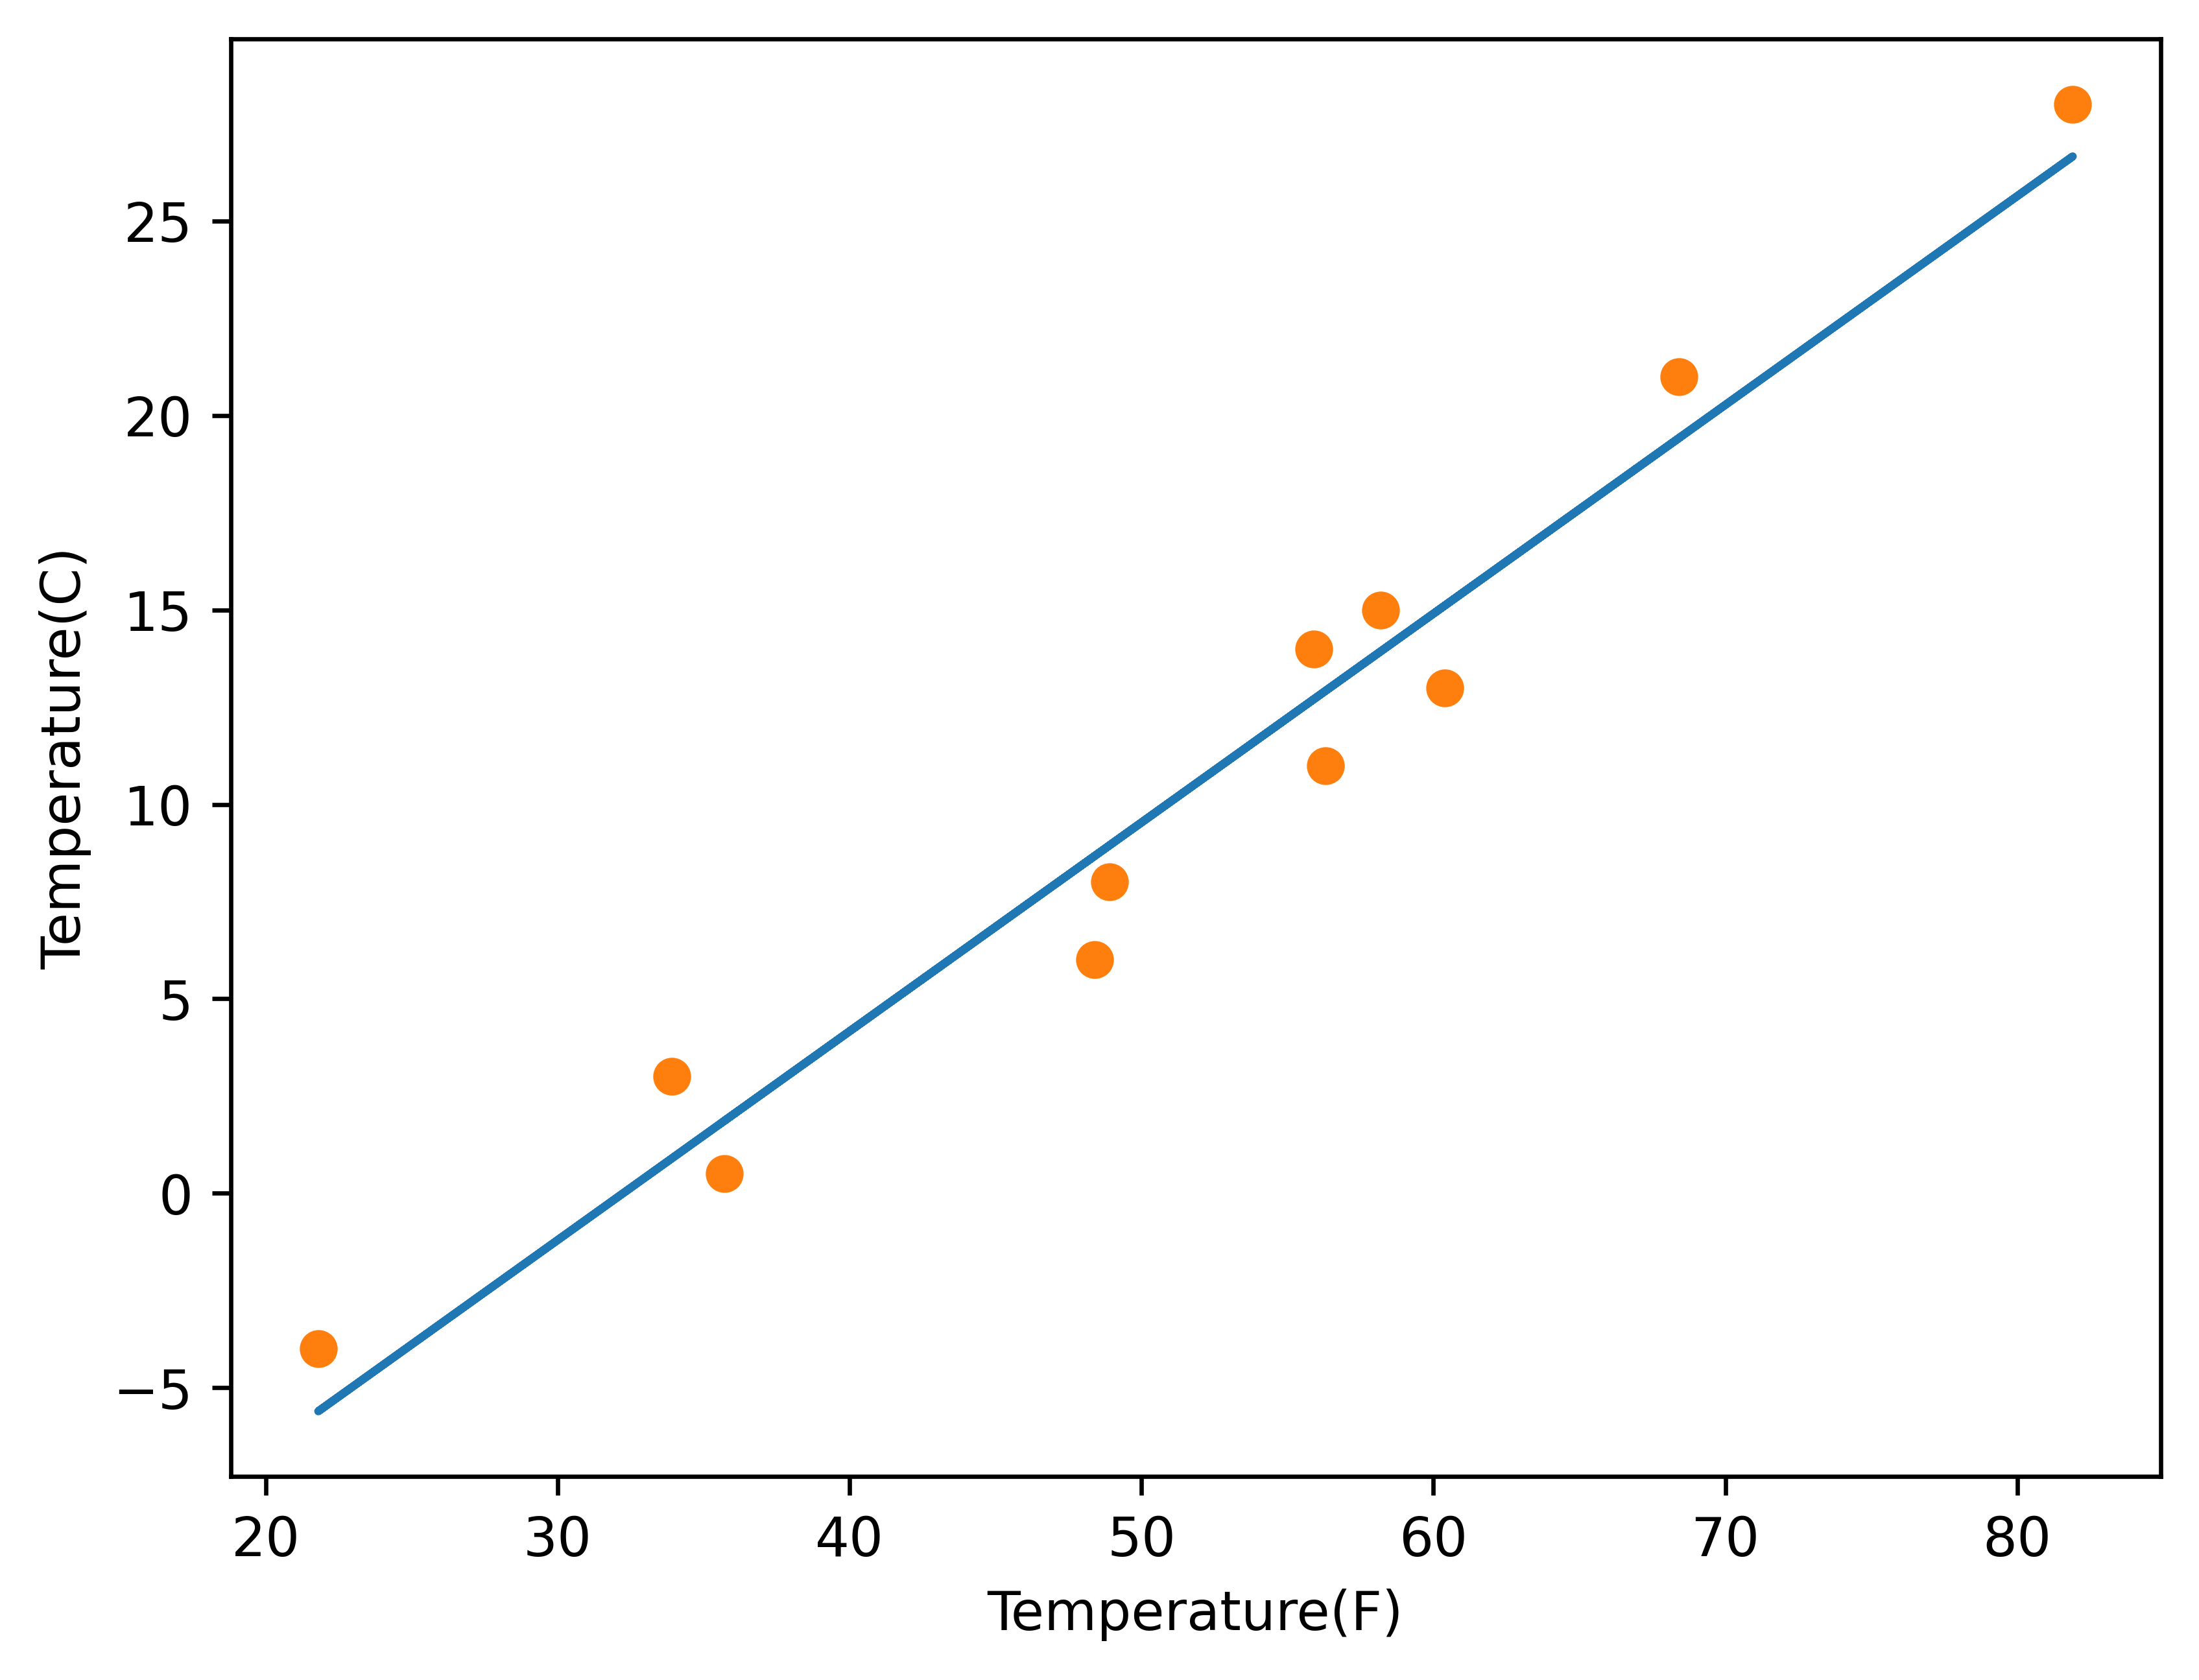

In [21]:
t_p = model(t_nu, *params)
fig = plt.figure(dpi=600)
plt.xlabel("Temperature(F)")
plt.ylabel("Temperature(C)")
plt.plot(t_u.numpy(), t_p.detach().numpy())
plt.plot(t_u.numpy(), t_c.numpy(), 'o')

上图实线为线性拟合模型的数据，圆点为输入数据

### PyTorch 自动求导

在之前的例子中，我们看到了一个简单的反向传播的例子：通过使用链式规则反向传播导数，我们计算了模型和损失的复合函数关于其内部参数 `w` 和 `b` 的梯度。这里的基本要求是我们处理的所有函数都是可微的。

即使我们有一个包含数百万个参数的复杂模型，只要我们的模型是可微的，计算关于参数的损失梯度就是写出导数的解析表达式并计算一次，当然这个方法并不会很有趣。这时 `PyTorch` 张量就会发挥作用。

`PyTorch` 可以记住它们从何而来，根据产生它们的操作和父张量，它们可以根据输入自动提供这些操作的导数链。这意味着我们不需要手动推导模型，给定一个前向表达式，无论嵌套如何， `PtTorch` 都会自动提供表达式相对其输入参数的梯度。

接下来尝试使用自动求导来替换之前的逻辑，首先初始化一个参数张量：

In [22]:
params = torch.tensor([1.0, 0.0], requires_grad=True)

注意传入的 `requires_grad=True` ，这个参数告诉 `PyTorch` 跟踪由对 `params` 张量进行操作后产生的整个系谱图。换句话说，任何将 `params` 作为祖先的张量都可以访问从 `params` 到那个张量的函数链。如果说这些函数是可微的，导数的值将自动填充为 `params` 张量的 `grad` 属性。

通常情况下，该属性值为 `None`:

In [23]:
params.grad is None

True

我们现在需要做的是从一个 `requires_grad` 为 `True` 的张量开始，调用模型并计算损失，然后反向调用损失张量：

In [24]:
loss = loss_fn(model(t_u, *params), t_c)
loss.backward()
params.grad

tensor([4517.2969,   82.6000])

此时， `params` 的 `grad` 属性包含关于 `params` 的每个元素的损失的导数。

我们可以有任意数量的 `requires_grad` 为 `True` 的张量和任意组合的函数。在这种情况下， `PyTorch` 将计算整个函数调用链中损失的导数，并将它们的值累加到这些张量的 `grad` 函数中。

需要注意的是，调用 `backward()` 方法将导致导数在叶节点上累加。使用梯度进行更新后，我们需要显式的将梯度归零：

In [25]:
if params.grad is not None:
    params.grad.zero_()

接下来看看自动求导的训练代码从头到尾的样子：

In [26]:
def training_loop(n_epochs, learning_rate, params, t_u, t_c):
    for epochs in range(1, n_epochs+1):
        if params.grad is not None:
            params.grad.zero_()
        
        t_p = model(t_u, *params)
        loss = loss_fn(t_p, t_c)
        loss.backward()
        
        with torch.no_grad():
            params -= learning_rate * params.grad
        
        if epochs % 500 == 0:
            print('Epoch %d, Loss %f'%(epochs, float(loss)))
    
    return params

在上面的代码中需要注意的是：

    1. 使用 `Python` 的 `with` 语句将更新操作封装在非梯度上下文中，这意味着在 `with` 语句块中， `PyTorch` 自动求导机制将不生效：也就是说不向前向图中添加边。
    
    2. 我们在适当的地方更新 `params` 张量，这意味着我们使用相同的 `params` 张量，但从中减去更新的值。当使用自动求导时，我们通常避免就地更新，因为 `PyTorch` 的自动求导引擎可能需要我们修改反向传播的值。

接下来看看新的训练函数是否有效：

In [27]:
training_loop(n_epochs = 5000, learning_rate = 1e-2, params = torch.tensor([1.0, 0], requires_grad=True), t_u = t_nu, t_c = t_c)

Epoch 500, Loss 7.860115
Epoch 1000, Loss 3.828538
Epoch 1500, Loss 3.092191
Epoch 2000, Loss 2.957698
Epoch 2500, Loss 2.933134
Epoch 3000, Loss 2.928648
Epoch 3500, Loss 2.927830
Epoch 4000, Loss 2.927679
Epoch 4500, Loss 2.927652
Epoch 5000, Loss 2.927647


tensor([  5.3671, -17.3012], requires_grad=True)

结果和之前得到的一样。这意味着虽然我们有能力手动计算导数，但我们不再需要这样做了。

### 优化器

在之前的实例代码中，我们使用了批量梯度下降进行优化，这在这个简单例子中运行良好。当然，有一些优化策略和技巧可以帮助收敛，特别是当模型变得复杂时。接下来介绍 `PyTorch` 从用户代码中提取的优化策略，这就避免了我们必须自己更新模型中的每一个参数的繁琐工作。

`torch` 模块中有一个 `optim` 子模块，我们可以在其中找到实现不同优化算法的类：

In [28]:
import torch.optim as optim

dir(optim)

['ASGD',
 'Adadelta',
 'Adagrad',
 'Adam',
 'AdamW',
 'Adamax',
 'LBFGS',
 'NAdam',
 'Optimizer',
 'RAdam',
 'RMSprop',
 'Rprop',
 'SGD',
 'SparseAdam',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_functional',
 '_multi_tensor',
 'lr_scheduler',
 'swa_utils']

每个优化器构造函数都接受一个参数列表（ `PyTorch` 张量，通常将 `requires_grad` 设置为 `True` ）作为第一个输入。传递给优化器的所有参数都会被保留在优化器对象中，这样优化器就可以更新它们的值并访问它们的 `grad` 属性。

每个优化器都暴露两个方法： `zero_grad()` 和 `step()` ， `zero_grad()` 将在构造函数中传入的张量的 `grad` 属性归零， `step()` 根据特定优化器实现优化策略更新这些参数的值。

接下来使用梯度下降优化器：

In [29]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-5
optimizer = optim.SGD([params], lr=learning_rate)
t_p = model(t_u, *params)
loss = loss_fn(t_p, t_c)
optimizer.zero_grad()
loss.backward()
optimizer.step()
params

tensor([ 9.5483e-01, -8.2600e-04], requires_grad=True)

`SGD` 是一个随机梯度下降优化。在调用 `backward()` 方法前调用 `zero_grad()` 方法初始化梯度，调用完 `backward()` 方法后再调用 `step()` 方法更新参数。

接下来更新循环训练函数：

In [30]:
def training_loop(n_epochs, optimizer, params, t_u, t_c):
    for epochs in range(1, n_epochs+1):
        
        t_p = model(t_u, *params)
        loss = loss_fn(t_p, t_c)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if epochs % 500 == 0:
            print('Epoch %d, Loss %f'%(epochs, float(loss)))
    
    return params

In [31]:
params = torch.tensor([1.0, 0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr=learning_rate)

params = training_loop(n_epochs = 5000, optimizer=optimizer, params=params, t_u = t_nu, t_c = t_c)
params

Epoch 500, Loss 7.860115
Epoch 1000, Loss 3.828538
Epoch 1500, Loss 3.092191
Epoch 2000, Loss 2.957698
Epoch 2500, Loss 2.933134
Epoch 3000, Loss 2.928648
Epoch 3500, Loss 2.927830
Epoch 4000, Loss 2.927679
Epoch 4500, Loss 2.927652
Epoch 5000, Loss 2.927647


tensor([  5.3671, -17.3012], requires_grad=True)

同样，我们也得到了和之前的一样的结果。